<a href="https://colab.research.google.com/github/ZeyadSabbah/TrivagoRecommenderSystem/blob/master/TrivagoEDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mounting to Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/My Drive/Trivago/

/content/drive/My Drive/Trivago


# Loading Libraries & Datasets

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
item_metadata_filepath = './Datasets/raw_data/item_metadata.csv'
submission_popular_filepath = './Datasets/raw_data/submission_popular.csv'
train_filepath = './Datasets/raw_data/train.csv'
test_filepath = './Datasets/raw_data/test.csv'

submission_popular = pd.read_csv(submission_popular_filepath)
item_metadata = pd.read_csv(item_metadata_filepath)
train = pd.read_csv(train_filepath)
test = pd.read_csv(test_filepath)

# Understanding Different Datasets

## train

Number of rows

In [5]:
train.shape[0]

15932992

Number of columns

In [6]:
train.shape[1]

12

Data Columns and Types

In [ ]:
train.dtypes

user_id            object
session_id         object
timestamp           int64
step                int64
action_type        object
reference          object
platform           object
city               object
device             object
current_filters    object
impressions        object
prices             object
dtype: object

How does the data look like?

In [ ]:
train.tail()

,user_id,session_id,timestamp,step,action_type,reference,platform,city,device,current_filters,impressions,prices
15932987,ZYNMLE3MV3LK,62728015bec05,1541544490,15,interaction item image,6617798,PT,"Paris, France",desktop,NaN,NaN,NaN
15932988,ZYNMLE3MV3LK,62728015bec05,1541544491,16,clickout item,6617798,PT,"Paris, France",desktop,Focus on Distance,6617798|1263420|9567886|1161323|149768|1890735...,58|96|55|75|90|60|233|104|150|145|328|207|150|...
15932989,ZYNMLE3MV3LK,62728015bec05,1541544540,17,clickout item,2712342,PT,"Paris, France",desktop,Focus on Distance,6617798|1263420|9567886|1161323|149768|1890735...,58|96|55|75|90|60|233|104|150|145|328|207|150|...
15932990,ZYNMLE3MV3LK,62728015bec05,1541544967,18,change of sort order,interaction sort button,PT,"Paris, France",desktop,NaN,NaN,NaN
15932991,ZYNMLE3MV3LK,62728015bec05,1541544973,19,clickout item,1161323,PT,"Paris, France",desktop,Focus on Distance,6617798|1263420|9567886|1161323|149768|1890735...,58|96|55|75|90|60|233|104|150|145|328|207|150|...


**Brief Explanation**
* Final Click-out in each session represented in action_type attribute is the 
most important step for the click through rate. Any session can contain zero, one, or many click-outs, though.Trivago concentrates at this for the profit calculation. All features required to be engineered is based on predicting the final click out action.  
* Each user has an id, each user can have one or more separated sessions. There is a recorded timestamp for each step the user is taking on the website or on the app, and steps are counted in each session through the count going from one till the end when the user leaves the session.  
The step can be anything from checking a rating to viewing an image to changing an order of the list to other actions that has to do with items (accommodations).
* Accommodations have ids shown in reference attribute, these accommodations are displayed to the user in the form of list, and the list can vary from just one item up to 25 items.  
* The shown items are put in a string separated by a pipe in the impressions attribute, matching this order is the prices list separated by a pipe as well in the prices attribute. (These two attributes do not have a value unless the action_type attribute is 'clickout'.  
* The platform attribute contains the location from where the user is checking the website or the app, while the city is the location where they are looking for the accommodation in, and device shows which device they are actually using.  
* The current_filters attribute shows what the filters the user has specified in their search for the suitable accommodation to themselves.

## test

Number of rows

In [7]:
test.shape[0]

3782335

Number of columns

In [8]:
test.shape[1]

12

Test set has the same columns and types as train set. Only it has the labels replaced with NaN values. It can be represented in the reference column.

In [ ]:
test.tail(1)

,user_id,session_id,timestamp,step,action_type,reference,platform,city,device,current_filters,impressions,prices
3782334,ZZCM39YKI3NR,6226bde1465e7,1541601178,1,clickout item,NaN,IT,"Dublin, Ireland",mobile,NaN,46149|109974|46119|8333280|12455|1185556|84002...,138|138|156|153|128|202|145|137|105|68|133|167...


## submission_popular

This is the form on how the test set predictions should be submitted.

In [ ]:
submission_popular.head(2)

,user_id,session_id,timestamp,step,item_recommendations
0,000324D9BBUC,89643988fdbfb,1541593942,10,924795 106315 1033140 119494 101758 903037 105...
1,0004Q49X39PY,9de47d9a66494,1541641157,1,3505150 3812004 2227896 2292254 3184842 222702...


Taking a session as an example to understand what is being represented in the submission_popular dataset in relation with test set.

In [ ]:
test[test.session_id=='9de47d9a66494']

,user_id,session_id,timestamp,step,action_type,reference,platform,city,device,current_filters,impressions,prices
1030763,0004Q49X39PY,9de47d9a66494,1541641157,1,clickout item,NaN,PH,"Iloilo City, Philippines",mobile,NaN,2213014|3184842|10213134|4504242|4486372|38120...,53|40|112|57|76|29|42|37|66|66|26|43|28|46|28|...


If we take a look at the impressions of this session at the test set, and the item_recommendations in submission_popular, we will find that they are the same items, only with difference in the order and also the separator.

In [ ]:
test_impressions = test[test.session_id=='9de47d9a66494'].impressions.values[0].split('|')
item_recommendations = submission_popular[submission_popular.session_id=='9de47d9a66494'].item_recommendations.values[0].split(' ')

sorted(test_impressions) == sorted(item_recommendations)

True

## item_metadata

What does the data look like?

In [ ]:
item_metadata.head()

,item_id,properties
0,5101,Satellite TV|Golf Course|Airport Shuttle|Cosme...
1,5416,Satellite TV|Cosmetic Mirror|Safe (Hotel)|Tele...
2,5834,Satellite TV|Cosmetic Mirror|Safe (Hotel)|Tele...
3,5910,Satellite TV|Sailing|Cosmetic Mirror|Telephone...
4,6066,Satellite TV|Sailing|Diving|Cosmetic Mirror|Sa...


The item_metadata set contains the properties for each item id (mentioned before in reference attributes in other datasets). The properties are also separated by a pipe and in the string format.

# Research Questions

**What is the timeline of the training set?**

In [10]:
from datetime import datetime

latest_timestamp = train.timestamp.max()
earliest_timestamp = train.timestamp.min()
print(datetime.fromtimestamp(latest_timestamp) - datetime.fromtimestamp(earliest_timestamp))

5 days, 23:59:51


**What is the timeline of the testing set?**

In [11]:
latest_timestamp = test.timestamp.max()
earliest_timestamp = test.timestamp.min()
print(datetime.fromtimestamp(latest_timestamp) - datetime.fromtimestamp(earliest_timestamp))

1 day, 23:59:52


The training data is gathered over 6 days, while the test data is over 2 days.

**Which dates were training datapoints were gathered on?**

In [13]:
latest_timestamp = train.timestamp.max()
earliest_timestamp = train.timestamp.min()

latest_date = datetime.fromtimestamp(latest_timestamp)
earliest_date = datetime.fromtimestamp(earliest_timestamp)

print('The starting and earliest datapoint gathered was on', earliest_date, '.')
print('The ending and last datapoing gathered was on', latest_date, '.')

The starting and earliest datapoint gathered was on 2018-11-01 00:00:08 .
The ending and last datapoing gathered was on 2018-11-06 23:59:59 .


**Which dates were testing datapoints were gathered on?**

In [14]:
latest_timestamp = test.timestamp.max()
earliest_timestamp = test.timestamp.min()

latest_date = datetime.fromtimestamp(latest_timestamp)
earliest_date = datetime.fromtimestamp(earliest_timestamp)

print('The starting and earliest datapoint gathered was on', earliest_date, '.')
print('The ending and last datapoing gathered was on', latest_date, '.')

The starting and earliest datapoint gathered was on 2018-11-07 00:00:07 .
The ending and last datapoing gathered was on 2018-11-08 23:59:59 .


The train and test sets are over 8 consecutive days.

**What days of the week for the train set?**


In [16]:
import calendar

latest_timestamp = train.timestamp.max()
earliest_timestamp = train.timestamp.min()

latest_date = datetime.fromtimestamp(latest_timestamp)
earliest_date = datetime.fromtimestamp(earliest_timestamp)

first_day = calendar.day_name[earliest_date.weekday()]
last_day = calendar.day_name[latest_date.weekday()]

print(first_day, 'to', last_day, '.')

Thursday to Tuesday .


**What days of the week for the test set?**

In [17]:
latest_timestamp = test.timestamp.max()
earliest_timestamp = test.timestamp.min()

latest_date = datetime.fromtimestamp(latest_timestamp)
earliest_date = datetime.fromtimestamp(earliest_timestamp)

first_day = calendar.day_name[earliest_date.weekday()]
last_day = calendar.day_name[latest_date.weekday()]

print(first_day, 'to', last_day, '.')

Wednesday to Thursday .


**What is the distribution of the number of steps in sessions?**

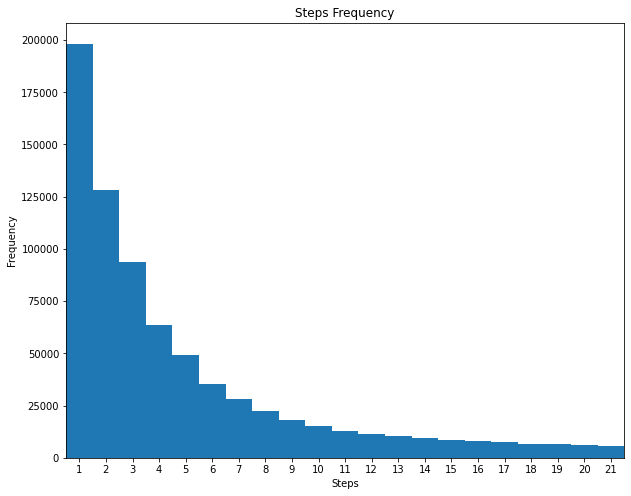

In [21]:
bin_size = 1
sessions_steps = train.groupby('session_id', sort=False).timestamp.count()
bin_edges = np.arange(0.5, sessions_steps.max() + bin_size, bin_size)
x_locs = np.arange(0.5, 21.5, 1) + 0.5
x_labels = np.arange(1, 22, 1)

plt.figure(figsize=[10, 8])
plt.hist(sessions_steps, bins=bin_edges)
plt.xticks(x_locs, x_labels)
plt.xlim([0.5, 21.5])
plt.xlabel('Steps')
plt.ylabel('Frequency')
plt.title('Steps Frequency')
plt.show()

The number of steps is right skewed, an interesting observation is that there is actually many sessions with only one step.

**What is the duration distribution of sessions' duration?**

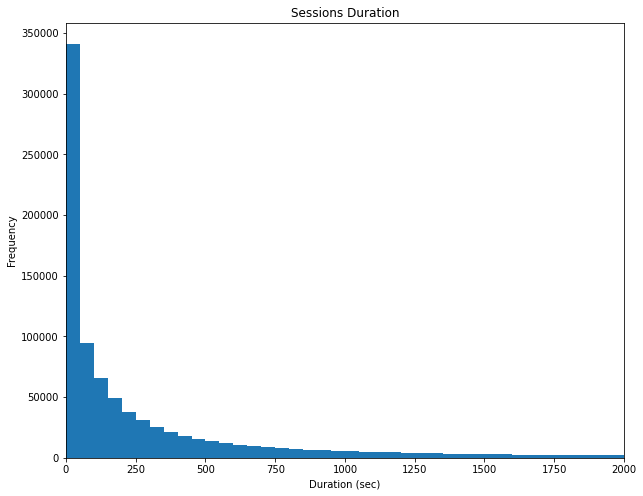

In [ ]:
sessions_duration = train.groupby('session_id', sort=False).timestamp.max() - train.groupby('session_id', sort=False).timestamp.min()
bin_size = 50
bin_edges = np.arange(0, 2000 + bin_size, bin_size)

plt.figure(figsize=[10, 8])
plt.hist(sessions_duration, bins=bin_edges)
plt.xlim([0, 2000])
plt.xlabel('Duration (sec)')
plt.ylabel('Frequency')
plt.title('Sessions Duration')
plt.show()

The data is right skewed. Logarithmic transformation would be much of a help in this case.

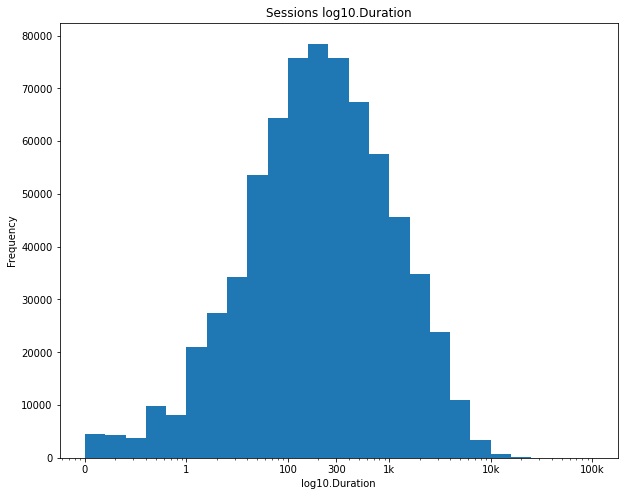

In [ ]:
bin_size = 0.2
bin_edges = 10 ** np.arange(0, 5 + bin_size, bin_size)

plt.figure(figsize=[10, 8])
plt.hist(sessions_duration, bins=bin_edges)
x_locs = [1e0, 1e1, 1e2, 3e2, 1e3, 1e4, 1e5]
x_labels = ['0', '1', '100', '300', '1k', '10k', '100k']
plt.xscale('log')
plt.xticks(x_locs, x_labels)
plt.xlabel('log10.Duration')
plt.ylabel('Frequency')
plt.title('Sessions log10.Duration')
plt.show()

**What is the action distribution?**

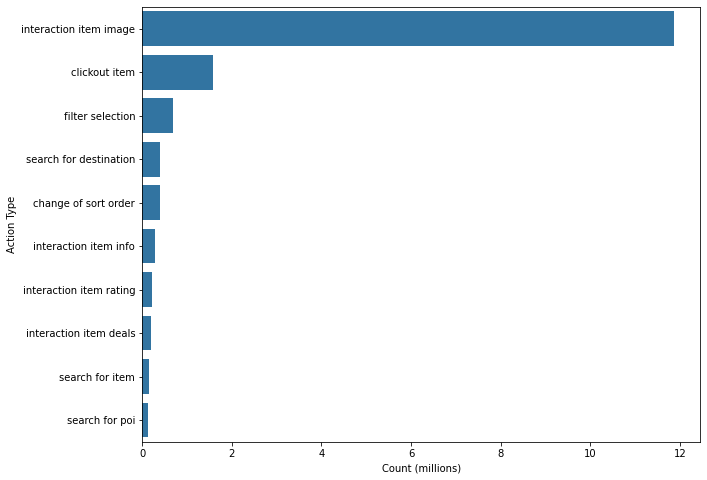

In [22]:
action_type_order = train.action_type.value_counts().index
base_color = sns.color_palette()[0]

plt.figure(figsize=[10, 8])
sns.countplot(data=train, y='action_type', color=base_color, order=action_type_order)
x_locs = [0, 0.2e7, 0.4e7, 0.6e7, 0.8e7, 1e7, 1.2e7]
x_labels = ['0', '2', '4', '6', '8', '10', '12']
plt.xlabel('Count (millions)')
plt.ylabel('Action Type')
plt.xticks(x_locs, x_labels)
plt.show()

It seems like users like to check for the images of the accommodations the most. Disregarding the 'interaction item image' to check the other attributes values. 'clickout item' comes second.

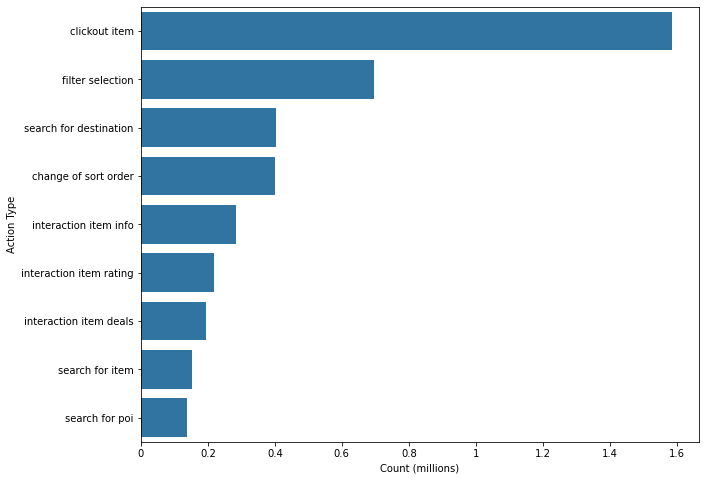

In [23]:
action_type_order = train[train.action_type!='interaction item image'].action_type.value_counts().index
base_color = sns.color_palette()[0]

plt.figure(figsize=[10, 8])
sns.countplot(data=train, y='action_type', color=base_color, order=action_type_order)
x_locs = [0, 0.2e6, 0.4e6, 0.6e6, 0.8e6, 1e6, 1.2e6, 1.4e6, 1.6e6]
x_labels = ['0', '0.2', '0.4', '0.6', '0.8', '1', '1.2', '1.4', '1.6']
plt.xlabel('Count (millions)')
plt.ylabel('Action Type')
plt.xticks(x_locs, x_labels)
plt.show()

**What is the distribution of the platforms used?**

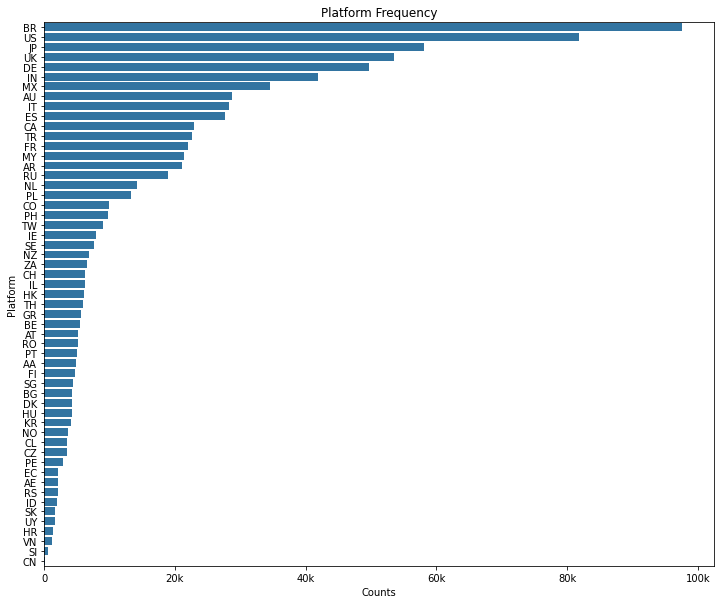

In [24]:
clickout_df = train[train.action_type=='clickout item'].groupby('session_id', sort=False).tail(1)
base_color = sns.color_palette()[0]
platform_order = clickout_df.platform.value_counts().index
plt.figure(figsize=[12, 10])
sns.countplot(data=clickout_df, y='platform', color=base_color, order=platform_order)
plt.title('Platform Frequency')
plt.xlabel('Counts')
plt.ylabel('Platform')
x_locs = np.arange(0, 1e5 + 1, 2e4)
x_labels = ['0', '20k', '40k', '60k', '80k', '100k']
plt.xticks(x_locs, x_labels)
plt.show()

This shows that the highest number of users are from Brazil, comes second United States, and so on.

**What is the distribution of the worlds' accommodations selected?**

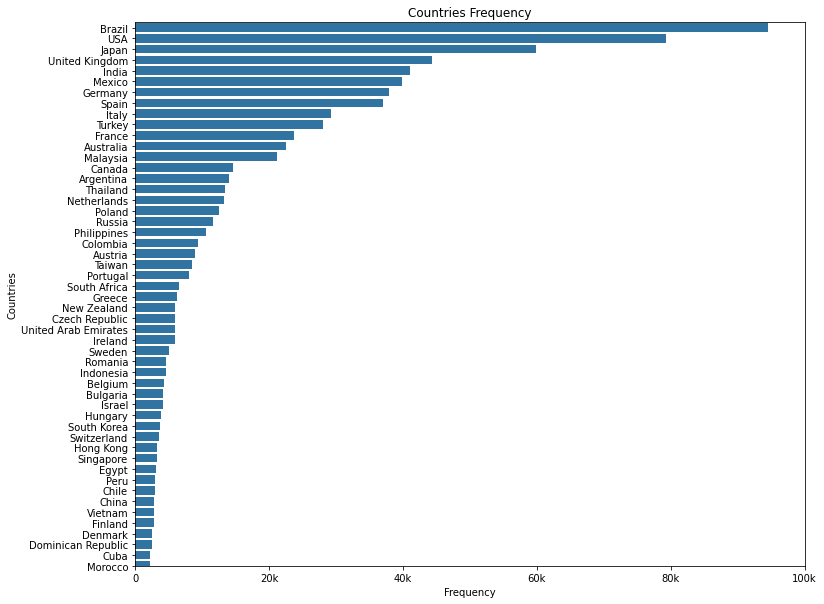

In [ ]:
countries = clickout_df.city.apply(lambda x: x.split(',')[1]).apply(lambda x: x.strip())
countries_order = countries.value_counts().index

plt.figure(figsize=[12, 10])
sns.countplot(y=countries, color=base_color, order=countries_order)
plt.ylim(50)
plt.xlabel('Frequency')
plt.ylabel('Countries')
plt.title('Countries Frequency')
x_locs = np.arange(0, 1e5 + 1, 2e4)
x_labels = ['0', '20k', '40k', '60k', '80k', '100k']
plt.xticks(x_locs, x_labels)
plt.show()

The highest countries in terms of accommodations' booking are Brazil, then United Kingdom, and so on.

**What is the traffic across the week?**

In [25]:
clickout_df['date_time'] = clickout_df.timestamp.apply(lambda x: datetime.fromtimestamp(x))
clickout_df['day_of_week'] = clickout_df.date_time.apply(lambda x: calendar.day_name[x.weekday()])
day_of_week_order = ['Thursday', 'Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday']
week = pd.api.types.CategoricalDtype(categories=day_of_week_order, ordered=True)

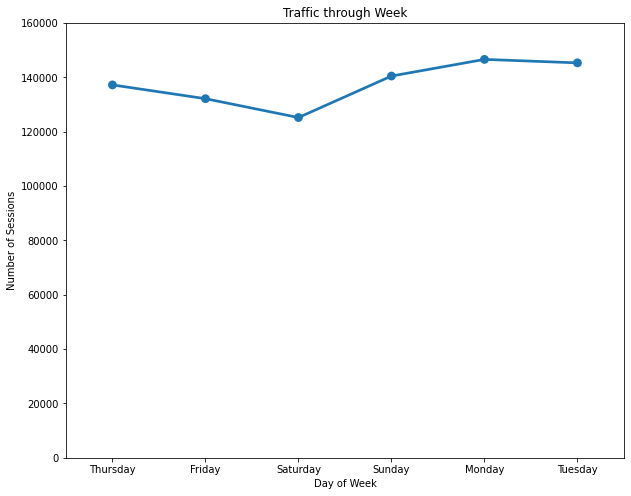

In [26]:
day_of_week_order = ['Thursday', 'Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday']
sessions_day = clickout_df.groupby('day_of_week').session_id.count()

plt.figure(figsize=[10, 8])
sns.pointplot(x=sessions_day.index, y=sessions_day.values, order=day_of_week_order)
plt.ylim([0, 160000])
plt.ylabel('Number of Sessions')
plt.xlabel('Day of Week')
plt.title('Traffic through Week')
plt.show()

Users might be more active, and there might be more traffic at the start of the week going on.

**What is the relationship between number of steps and duration in the sessions?**

In [27]:
sessions_duration = train.groupby('session_id', sort=False).timestamp.max() - \
                    train.groupby('session_id', sort=False).timestamp.min()
sessions_duration = sessions_duration.reset_index().rename(columns={'timestamp':'duration'})
clickout_df = clickout_df.merge(sessions_duration, on='session_id', how='left')

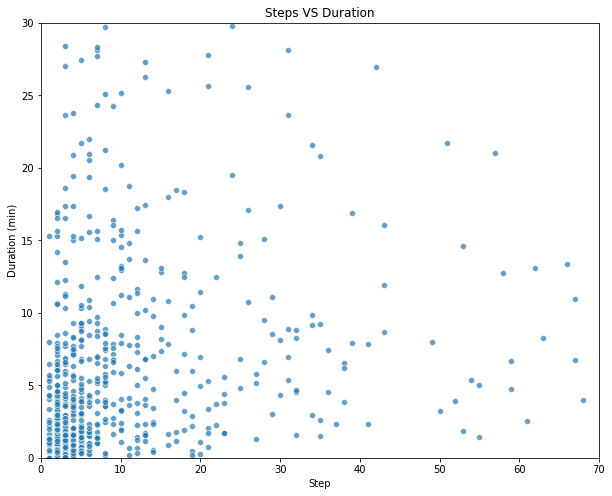

In [28]:
np.random.seed(42)
clickout_df_sample = clickout_df.sample(1000)
plt.figure(figsize=[10, 8])
sns.scatterplot(clickout_df_sample.step, clickout_df_sample.duration/(60), alpha=0.7)
plt.xlim([0, 70])
plt.ylim([0, 30])
plt.xlabel('Step')
plt.ylabel('Duration (min)')
plt.title('Steps VS Duration')
plt.show()

This graph is only a sample plot due to the overplotting. There is a positive correlation between Durstion of the sessions and number of steps.

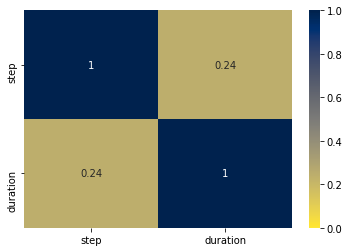

In [ ]:
sns.heatmap(clickout_df[['step', 'duration']].corr(), cmap='cividis_r', annot=True, vmin=0);

**How good is Trivago's Recommender Engine doing?**

In [29]:
def get_list(List):
  items_list = List.split('|')
  return items_list

def get_rank(reference, List):
  ''' Function that gets the rank of user's item selection '''
  try:
    rank = get_list(List).index(reference) + 1
  except:
    rank = 0
  return rank

In [30]:
clickout_df['rank'] = clickout_df.apply(lambda x: get_rank(x.reference, x.impressions), axis=1).values

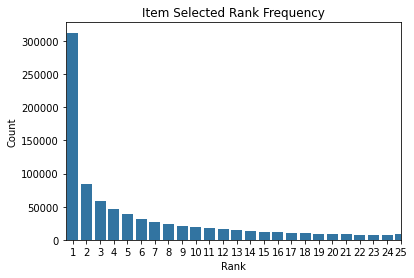

In [31]:
sns.countplot(data=clickout_df, x='rank', color=base_color)
plt.xlim([0.5, 25])
plt.xlabel('Rank')
plt.ylabel('Count')
plt.title('Item Selected Rank Frequency');

**What is the percentage of users who click on the first item they see?**

In [32]:
round(len(clickout_df[clickout_df['rank']==1])/len(clickout_df), 3)*100

37.8

**Do devices play a role in the rank of item selected?**

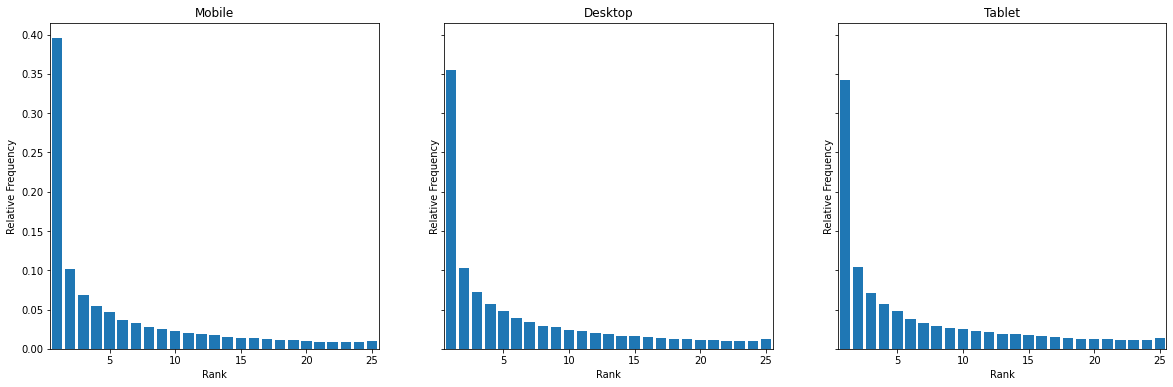

In [40]:
mobile_rf = clickout_df[clickout_df.device=='mobile']['rank'].value_counts()/len(clickout_df[clickout_df.device=='mobile'])
desktop_rf = clickout_df[clickout_df.device=='desktop']['rank'].value_counts()/len(clickout_df[clickout_df.device=='desktop'])
tablet_rf = clickout_df[clickout_df.device=='tablet']['rank'].value_counts()/len(clickout_df[clickout_df.device=='tablet'])

fig, axes = plt.subplots(1, 3, sharey=True, figsize=[20, 6])
dfs = [mobile_rf, desktop_rf, tablet_rf]
names = ['Mobile', 'Desktop', 'Tablet']
for i in range(3):
  plt.sca(axes[i])
  plt.bar(dfs[i].index, dfs[i].values)
  plt.xlim([0.5, 25.5])
  plt.xlabel('Rank')
  plt.ylabel('Relative Frequency')
  plt.title(names[i])

It seems there is no difference in the distributions of the three devices, but in order to be more confident about that, bootstrapping sampling technique can be used to simulate the null hypothesis of them being equal.  
The reason why I am focusing on this point is that the display on each screen of these devices is different, for example the mobile may be able to show only 3 items, while the tablet 4, and the desktop 5. This might affect the user's decision in selecting the accommodation.

**What is the selected items' prices distribution?**

In [41]:
def get_price(List, rank):
  try:
    items_list = List.split('|')
    price = items_list[rank]
  except:
    price = np.nan
  return price

In [42]:
clickout_df['price'] = clickout_df.apply(lambda x: get_price(x.prices, x['rank'] - 1), axis=1).values

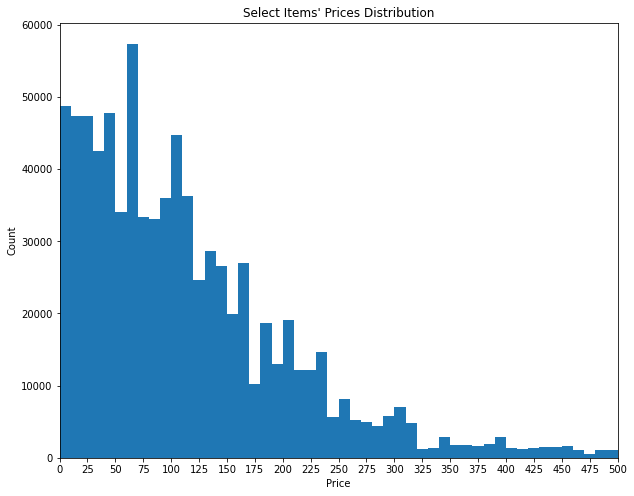

In [43]:
plt.figure(figsize=[10, 8])
bin_edges = np.arange(0, 510, 10)
plt.hist(clickout_df['price'], bins=bin_edges)
plt.xlim([0, 500])
plt.xticks([])
x_ticks = np.arange(0, 525, 25)
plt.xticks(x_ticks, x_ticks)
plt.xlabel('Price')
plt.ylabel('Count')
plt.title("Select Items' Prices Distribution");

**What is the relation between Rank and Average Step?**   

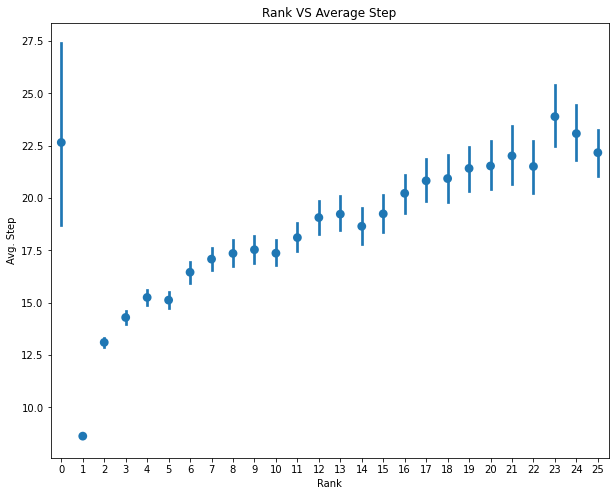

In [44]:
plt.figure(figsize=[10, 8])
sns.pointplot(data=clickout_df, x='rank', y='step', linestyles='')
plt.xlabel('Rank')
plt.ylabel('Avg. Step')
plt.title('Rank VS Average Step')
plt.show()

In general, this graph shows that the more the user takes step, the more likely they end up with an item that is not in the top of the list.  
The zero value of rank indicates that the choice of the user was not in the list in the first place. There might be a technical explanation for that such as the user was viewing from different tabs and the clickout was made from the tab that did no include the item.  
The large whisker in Zero means that there is no enough data available, for this point. On the other hand, the whisker keeps getting larger going from rank 1 to 25, that's because of the distribution of the data having rank 1 on the top for example.

**What is the relation between Rank and Average Step in the terms of devices?**

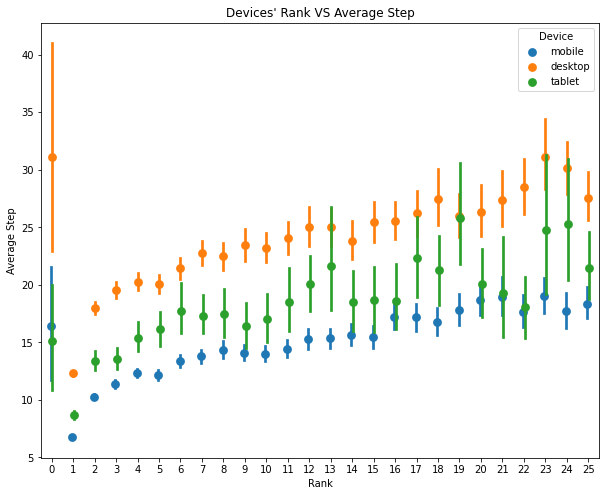

In [45]:
plt.figure(figsize=[10, 8])
sns.pointplot(data=clickout_df, x='rank', y='step', hue='device', linestyles='', dodge=True)
plt.xlabel('Rank')
plt.ylabel('Average Step')
plt.legend(title='Device')
plt.title("Devices' Rank VS Average Step")
plt.show()

The relationship seems to be the same, only shifted when it comes to the device used. The desktop user makes more steps than the tablet and mobile user for the same rank, and the tablet user makes more steps than mobile user for the same rank.  
One explanation to this graph can be user feels more comfortable surfing the website on the desktop and takes their times checking accommodations than on smaller devices.